In [1]:
import os, sys
sys.path.append(os.path.abspath(".."))

from src.functions import (
    load_config, read_csv_from_config,
    normalize_columns, clean_runners_pipeline,
    winners_wide_to_long,
    top_countries_by_wins, winners_by_decade_and_country,
    plot_top_countries_bar, plot_decade_country_stacked
)

# Load config
config = load_config("../config.yaml")

# Read datasets from config
df_data = read_csv_from_config(config, "marathon_data", low_memory=False)
df_winners = read_csv_from_config(config, "marathon_winners", low_memory=False)

print("Data shape:", df_data.shape)
print("Winners shape:", df_winners.shape)


Data shape: (884944, 5)
Winners shape: (50, 7)


In [2]:
import pandas as pd

# Load your runners dataset (adjust the path as needed)
df = pd.read_csv("../data/clean/cleaned_marathon.csv")

# Convert finishing times into timedelta format (HH:MM:SS → duration)
df['time_td'] = pd.to_timedelta(df['time'], errors='coerce')

# Select the winners: for each (year, gender), find the row with the minimum finishing time
winners = df.loc[df.groupby(['year', 'gender'])['time_td'].idxmin()].copy()

# Sort the winners by year and gender, reset index for clarity
winners = winners.sort_values(['year', 'gender']).reset_index(drop=True)

winners.head()


,year,gender,time,finish_time,finish_seconds,time_td
0,1974,female,03:22:01,0 days 03:22:01,12121.0,0 days 03:22:01
1,1974,male,02:44:53,0 days 02:44:53,9893.0,0 days 02:44:53
2,1975,female,03:59:15,0 days 03:59:15,14355.0,0 days 03:59:15
3,1975,male,02:47:08,0 days 02:47:08,10028.0,0 days 02:47:08
4,1976,male,02:23:08,0 days 02:23:08,8588.0,0 days 02:23:08


In [3]:
import pandas as pd

# Load cleaned winners dataset
winners = pd.read_csv("../data/clean/cleaned_marathon_winners.csv")

print("Shape;", winners.shape)
print("Columns:", winners.columns.tolist())
winners.head()


Shape; (100, 5)
Columns: ['year', 'winner', 'country', 'time', 'gender']


,year,winner,country,time,gender
0,1974,Günter Hallas,West Germany,2:44:53,male
1,1975,Ralf Bochröder,West Germany,2:47:08,male
2,1976,Ingo Sensburg,West Germany,2:23:08,male
3,1977,Günter Mielke,West Germany,2:15:19,male
4,1978,Michael Spöttel,West Germany,2:20:03,male


In [4]:
# Count total wins by country
country_wins = (
    winners['country']
    .value_counts()
    .reset_index()
    .rename(columns={'index':'country', 'country':'wins'})
)

country_wins.head(10)
# Here we calculate how many times each country has produced a Berlin Marathon winner.

# This allows us to identify the most dominant countries overall.

,wins,count
0,Kenya,25
1,Ethiopia,20
2,West Germany,17
3,Japan,6
4,United Kingdom,5
5,Poland,4
6,Germany,4
7,Belgium,3
8,Tanzania,3
9,South Africa,3


In [5]:
#Country dominance by decade

winners['decade'] = (winners['year'] // 10) * 10

wins_by_decade = (
    winners.groupby(['decade','country'])
    .size()
    .reset_index(name='wins')
    .sort_values(['decade','wins'], ascending=[True, False])
)

wins_by_decade.head(15)

# By grouping winners by decade, we can observe how country dominance has shifted over time.
# For example, East African countries (Kenya, Ethiopia) dominate in recent decades, while earlier winners came from Europe or the USA.


,decade,country,wins
0,1970,West Germany,12
9,1980,West Germany,5
8,1980,United Kingdom,4
7,1980,Tanzania,3
1,1980,Belgium,2
6,1980,Poland,2
2,1980,Colombia,1
3,1980,Denmark,1
4,1980,Finland,1
5,1980,Hungary,1


VISUALIZATIONS

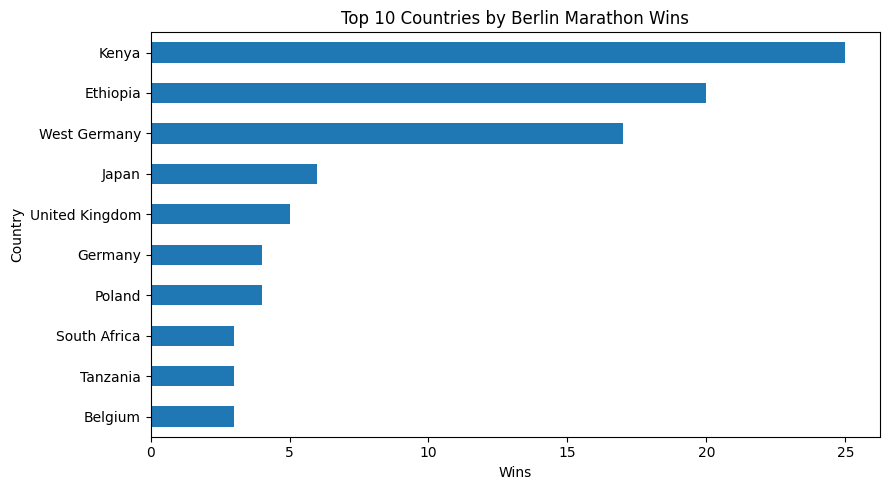

In [6]:
import matplotlib.pyplot as plt
from pathlib import Path

Path("figures").mkdir(exist_ok=True)

topN = 10
series_top = winners['country'].value_counts().head(topN).sort_values(ascending=True)

plt.figure(figsize=(9,5))
ax = series_top.plot(kind='barh', title=f"Top {topN} Countries by Berlin Marathon Wins")
ax.set_xlabel("Wins"); ax.set_ylabel("Country")
plt.tight_layout()
plt.savefig("figures/top_countries_total_wins.png", dpi=200)
plt.show()


<Figure size 1000x600 with 0 Axes>

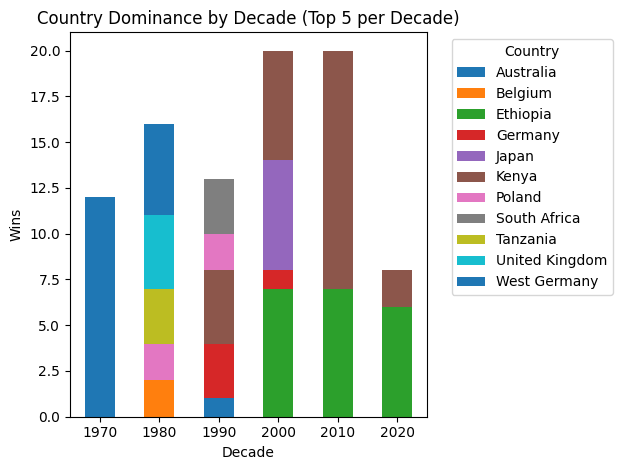

In [7]:
# Create decade and aggregate

winners['decade'] = (winners['year'] // 10) * 10
wins_by_decade = (winners
                  .groupby(['decade','country'])
                  .size()
                  .reset_index(name='wins'))

# Keep top 5 countries per decade for readability
top5_each_decade = (wins_by_decade
                    .sort_values(['decade','wins'], ascending=[True, False])
                    .groupby('decade').head(5))

pivot = top5_each_decade.pivot(index='decade', columns='country', values='wins').fillna(0)

plt.figure(figsize=(10,6))
ax = pivot.plot(kind='bar', stacked=True, title="Country Dominance by Decade (Top 5 per Decade)")
ax.set_xlabel("Decade"); ax.set_ylabel("Wins")
ax.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("figures/country_dominance_by_decade.png", dpi=200)
plt.show()
